# Introduction
It is almost axiomatic at this point that politicians' varying responses the the Covid-19 pandemic have had a meaningful and direct impact on their respective public perceptions. Morning Consult Inc. published the daily results of a series of approval surveys for dates across 2020.

I will combine this with state level case data from the New York Times to see if there is a meaningful correlation between current case-load and approval rating for statewide politicians (i.e. governors and senators)

# 1 Load Data
## 1.1 Import Packages
I will manage and manipulate the data using a pandas dataframe, so I will need to install the pandas package, as well as the numpy package. Visualization will be done with matplotlib, so I will need to install that package too.

I am also going to be scraping some information from the web. To do this, I will need the BeautifulSoup4 and requests.

In [1]:
#import packages: pandas, numpy, pyplot, BeautifulSoup, and requests
import pandas as pd
import numpy as mp

from bs4 import BeautifulSoup
import requests

import matplotlib.pyplot as plt

## 1.2 Import Data
I'll perform this analysis using four data sets. The first is daily approval ratings for governors and senators over the last two years. The second is state-level covid data from the New York Times github.

The remaining two datasets will contain the information about the senators and governors for each state. I'm going to get this data by scraping it from the web using BeautifulSoup. 

In [2]:
#read in the approval rating data and state-level covid infection data
survey = pd.read_csv('https://raw.githubusercontent.com/TLydon/SurveyData/master/JulyUpdate/Politicians_wout_House_July_2020.csv', parse_dates = [2])
st_covid = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv', parse_dates = [0])

In [3]:
#look at the covid data to see what needs to be altered
st_covid

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0
...,...,...,...,...,...
8589,2020-08-05,Virginia,51,95049,2274
8590,2020-08-05,Washington,53,62390,1705
8591,2020-08-05,West Virginia,54,7159,124
8592,2020-08-05,Wisconsin,55,61247,979


In [4]:
#look at the survey data to see what needs to be altered
survey

,Unnamed: 0,question_id,series_date,total_n,Somewhat.Approve,Strongly.Approve,Somewhat.Disapprove,Strongly.Disapprove,Don.t.Know...No.Opinion
0,405,LEG2_Bernard_Sanders,2018-01-01 00:00:00+00:00,10,12,70,7,6,6
1,406,LEG2_Bernard_Sanders,2018-01-02 00:00:00+00:00,14,19,31,12,15,22
2,407,LEG2_Bernard_Sanders,2018-01-03 00:00:00+00:00,8,30,70,0,0,0
3,408,LEG2_Bernard_Sanders,2018-01-04 00:00:00+00:00,3,25,75,0,0,0
4,409,LEG2_Bernard_Sanders,2018-01-05 00:00:00+00:00,11,0,72,15,13,0
...,...,...,...,...,...,...,...,...,...
127881,668224,nr2a,2020-07-16 00:00:00+00:00,6226,19,21,11,42,6
127882,668225,nr2a,2020-07-17 00:00:00+00:00,5496,18,20,12,44,6
127883,668226,nr2a,2020-07-18 00:00:00+00:00,4661,19,21,12,41,6
127884,668227,nr2a,2020-07-19 00:00:00+00:00,4830,18,21,11,44,6


The Covid dataset is very clean and tidy. The only adjustment I may want to make is to backfill zeros for every state going back to Jan-21, so that every state is on the same time scale.

The survey data will take some work. All "question_id" fields starting with LEG1 are governors and LEG2 are senators. Everything else will be dropped. I'll create a new column for title, and remove the underscores. Unfortunately, I cannot just match on last name (Rick Scott and Tom Scott being the only flies in that ointment), so I will have to get more creative. Possibly separate columns for first, last, and title.

For the info on Senators, I will scrape the data from senate.gov using BeautifulSoup. The names are all stored in a table, which should make organizing the output into a dataframe relatively simple.

In [5]:
#use bs4 to find the table in the senators list page
url = "https://www.senate.gov/senators/index.htm"
source = requests.get(url).text
soup = BeautifulSoup(source, 'html.parser')
table = soup.find('table')
print(table.prettify())

<table cellspacing="0" class="display compact nowrap" id="listOfSenators" width="100%">
 <thead>
  <tr align="left">
   <th align="left" style="color:#4B4B4B">
    Senator's Name (Party-State)
   </th>
   <th align="left" style="color:#4B4B4B">
    State
   </th>
   <th align="left" style="color:#4B4B4B">
    Party
   </th>
   <th align="left" style="color:#4B4B4B">
    Class
   </th>
  </tr>
 </thead>
 <tbody>
  <tr>
   <td>
    <a href="http://www.alexander.senate.gov/">
     Alexander, Lamar (R-TN)
    </a>
   </td>
   <td>
    Tennessee
   </td>
   <td>
    Republican
   </td>
   <td>
    <span style="display: none;">
     2
    </span>
    Class II
   </td>
  </tr>
  <tr>
   <td>
    <a href="http://www.baldwin.senate.gov/">
     Baldwin, Tammy (D-WI)
    </a>
   </td>
   <td>
    Wisconsin
   </td>
   <td>
    Democrat
   </td>
   <td>
    <span style="display: none;">
     1
    </span>
    Class I
   </td>
  </tr>
  <tr>
   <td>
    <a href="http://www.barrasso.senate.gov">
   

In [6]:
#find all instances of tr in the table element
table_rows = table.find_all('tr')

#create an empty list to populate with table data
table_list = []

#use a for loop to append td fields to the empty list
for tr in table_rows:
    td = tr.find_all('td')
    row = [i.text for i in td]
    table_list.append(row)

#create a df from the list of lists, and name the columns
senators = pd.DataFrame(table_list, columns=['name', 'state', 'party', 'class'])
senators

,name,state,party,class
0,None,None,None,None
1,"Alexander, Lamar (R-TN)",Tennessee,Republican,2Class II
2,"Baldwin, Tammy (D-WI)",Wisconsin,Democrat,1Class I
3,"Barrasso, John (R-WY)",Wyoming,Republican,1Class I
4,"Bennet, Michael F. (D-CO)",Colorado,Democrat,3Class III
...,...,...,...,...
96,"Warren, Elizabeth (D-MA)",Massachusetts,Democrat,1Class I
97,"Whitehouse, Sheldon (D-RI)",Rhode Island,Democrat,1Class I
98,"Wicker, Roger F. (R-MS)",Mississippi,Republican,1Class I
99,"Wyden, Ron (D-OR)",Oregon,Democrat,3Class III


I'll gather the governor information using the same method, but with data coming from Wikipedia.

In [7]:
#use bs4 to find the table in the governors list page
url = "https://en.wikipedia.org/wiki/List_of_United_States_governors"
source = requests.get(url).text
soup = BeautifulSoup(source, 'html.parser')
govs = soup.find('tbody')
print(govs.prettify())

<tbody>
 <tr>
  <th colspan="11">
   <p>
    <span style="margin:0; font-size:90%; white-space:nowrap;">
     <span class="legend-text" style="border:1px solid #AAAAAA; padding:1px .6em; background-color:#3333FF; color:black; font-size:95%; line-height:1.25; text-align:center;">
     </span>
     <a href="/wiki/Democratic_Party_(United_States)" title="Democratic Party (United States)">
      Democratic
     </a>
    </span>
    <span style="font-size:85%;">
     (24)
    </span>
    <span style="margin:0; font-size:90%; white-space:nowrap;">
     <span class="legend-text" style="border:1px solid #AAAAAA; padding:1px .6em; background-color:#FF3333; color:black; font-size:95%; line-height:1.25; text-align:center;">
     </span>
     <a href="/wiki/Republican_Party_(United_States)" title="Republican Party (United States)">
      Republican
     </a>
    </span>
    <span style="font-size:85%;">
     (26)
    </span>
   </p>
  </th>
 </tr>
 <tr>
  <th>
   State
  </th>
  <th class="unsorta

In [8]:
#find all instances of tr in the table element
table_rows = govs.find_all('tr')

#create an empty list to populate with table data
govs_list = []

#use a for loop to append td fields to the empty list
for tr in table_rows:
    td = tr.find_all('td')
    row = [i.text for i in td]
    govs_list.append(row)

In [9]:
govs_list

[[],
 [],
 ['Alabama\n',
  '\n',
  'Kay Ivey\n',
  '\xa0\n',
  'Republican\n',
  ' (1944-10-15) October 15, 1944 (age\xa075)\n',
  'Lieutenant Governor, Treasurer\n',
  'April 10, 2017\n',
  '2023\n',
  'List\n'],
 ['Alaska\n',
  '\n',
  'Mike Dunleavy\n',
  '\xa0\n',
  'Republican\n',
  ' (1961-05-05) May 5, 1961 (age\xa059)\n',
  'Alaska Senate\n',
  'December 3, 2018\n',
  '2022\n',
  'List\n'],
 ['Arizona\n',
  '\n',
  'Doug Ducey\n',
  '\xa0\n',
  'Republican\n',
  ' (1964-04-09) April 9, 1964 (age\xa056)\n',
  'Treasurer\n',
  'January 5, 2015\n',
  '2023 (term limits)\n',
  'List\n'],
 ['Arkansas\n',
  '\n',
  'Asa Hutchinson\n',
  '\xa0\n',
  'Republican\n',
  ' (1950-12-03) December 3, 1950 (age\xa069)\n',
  'Under Secretary of Homeland Security for Border & Transportation Security, Administrator of the Drug Enforcement Administration, U.S. House, U.S. Attorney\n',
  'January 13, 2015\n',
  '2023 (term limits)\n',
  'List\n'],
 ['California\n',
  '\n',
  'Gavin Newsom\n',
  '\

In [10]:
#create a dataframe from the list of lists, and give the columns appropriate names
governors = pd.DataFrame(govs_list, columns=['state', 'portrait', 'governor', 'blank', 'party', 'born', 'exp', 'inaug', 'eot', 'past'])
governors

,state,portrait,governor,blank,party,born,exp,inaug,eot,past
0,None,None,None,None,None,None,None,None,None,None
1,None,None,None,None,None,None,None,None,None,None
2,Alabama\n,\n,Kay Ivey\n,\n,Republican\n,"(1944-10-15) October 15, 1944 (age 75)\n","Lieutenant Governor, Treasurer\n","April 10, 2017\n",2023\n,List\n
3,Alaska\n,\n,Mike Dunleavy\n,\n,Republican\n,"(1961-05-05) May 5, 1961 (age 59)\n",Alaska Senate\n,"December 3, 2018\n",2022\n,List\n
4,Arizona\n,\n,Doug Ducey\n,\n,Republican\n,"(1964-04-09) April 9, 1964 (age 56)\n",Treasurer\n,"January 5, 2015\n",2023 (term limits)\n,List\n
5,Arkansas\n,\n,Asa Hutchinson\n,\n,Republican\n,"(1950-12-03) December 3, 1950 (age 69)\n",Under Secretary of Homeland Security for Borde...,"January 13, 2015\n",2023 (term limits)\n,List\n
6,California\n,\n,Gavin Newsom\n,\n,Democratic\n,"(1967-10-10) October 10, 1967 (age 52)\n","Lieutenant Governor, Mayor of San Francisco\n","January 7, 2019\n",2023\n,List\n
7,Colorado\n,\n,Jared Polis\n,\n,Democratic\n,"(1975-05-12) May 12, 1975 (age 45)\n","U.S. House, Colorado State Board of Education\n","January 8, 2019\n",2023\n,List\n
8,Connecticut\n,\n,Ned Lamont\n,\n,Democratic\n,"(1954-01-03) January 3, 1954 (age 66)\n",Greenwich Selectman\n,"January 9, 2019\n",2023\n,List\n
9,Delaware\n,\n,John Carney\n,\n,Democratic\n,"(1956-05-20) May 20, 1956 (age 64)\n","U.S. House, Lieutenant Governor\n","January 17, 2017\n",2021\n,List\n


In [11]:
#keep only the state, governor, and party columns
governors = governors[['state', 'governor', 'party']]

# 2 Clean Data Files
While the Covid file is quite clean, the others need some pretty serious cleaning up. The survey file needs the most help, so I am going to begin with that one, as its final form will drive the needs of the cleaner files.

## 2.1 Cleaning the Survey File
In order to be merged and filtered accurately, the "question_id" field will need some serious mutation. I'll begin by extracting the position of each politician, then their first and last name. I'll extract position with a lambda function, then remove everything but the names, and split those across columns with regex.

In [12]:
#drop all cells that contain 'nr2a' in the question_id field
survey = survey[survey['question_id'] != "nr2a"]

#create a labmda function that checks if a cell contains "LEG2"
survey['office'] = survey['question_id'].apply(lambda x: 'SEN' if 'LEG2' in x else 'GOV')

<ipython-input-12-484691979170>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survey['office'] = survey['question_id'].apply(lambda x: 'SEN' if 'LEG2' in x else 'GOV')


In [13]:
#remove the "LEG_1" and "LEG_2" strings from question_id using .replace and a regex
survey.replace('LEG\d_', "", regex = True, inplace = True)

C:\Users\dalli\anaconda3\envs\Python and R Main\lib\site-packages\pandas\core\frame.py:4166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [14]:
#Create columns for first and last, using the split method, and assigning the result to new columns
first_last = survey["question_id"].str.split("_", n = 1, expand = True) 
survey[['first', 'last']] = first_last
survey.drop('question_id', axis = 1, inplace = True)

C:\Users\dalli\anaconda3\envs\Python and R Main\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\dalli\anaconda3\envs\Python and R Main\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [15]:
#rename the columns and change the order
survey.columns = ['drop', 'date', 'drop2', 'somewhat_approve', 'strongly_approve', 'somewhat_disapprove', 'strongly_disapprove', 'dont_know_no_opinion', 'office', 'first', 'last']
survey = survey[['date', 'office', 'first', 'last', 'strongly_approve', 'somewhat_approve', 'somewhat_disapprove', 'strongly_disapprove', 'dont_know_no_opinion']]

In [16]:
#filter only for dates in the during the covid-era
survey = survey[survey['date'] >= '2020-1-21']

In [17]:
#writing the cleaned up survey file to a csv as a stopgap
survey.to_csv('survey_clean.csv')

## 2.2 Cleaning the Governors File
I am going to use the survey file as the format that the other files will have to conform to. There are some names with unique strucutures, such as J. B. Pritzker and John Bel Edwards, and I will just conform to what the survey files used. Outside of that, the only changes needed are minor formatting issues.

In [18]:
#Drop the \n from each cell with a for loop
for col in governors.columns:
    governors[col] = governors[col].str[:-1]

<ipython-input-18-d845e024fc86>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  governors[col] = governors[col].str[:-1]


In [19]:
#Drop the top two rows
governors.drop([0, 1], axis=0, inplace = True)
governors

,state,governor,party
2,Alabama,Kay Ivey,Republican
3,Alaska,Mike Dunleavy,Republican
4,Arizona,Doug Ducey,Republican
5,Arkansas,Asa Hutchinson,Republican
6,California,Gavin Newsom,Democratic
7,Colorado,Jared Polis,Democratic
8,Connecticut,Ned Lamont,Democratic
9,Delaware,John Carney,Democratic
10,Florida,Ron DeSantis,Republican
11,Georgia,Brian Kemp,Republican


In [20]:
#fix the two odd party cells
governors.replace({"Democratic–Farmer–Labor":"Democratic", "Republican[note 1]":"Republican"}, inplace = True)
governors

C:\Users\dalli\anaconda3\envs\Python and R Main\lib\site-packages\pandas\core\frame.py:4166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,state,governor,party
2,Alabama,Kay Ivey,Republican
3,Alaska,Mike Dunleavy,Republican
4,Arizona,Doug Ducey,Republican
5,Arkansas,Asa Hutchinson,Republican
6,California,Gavin Newsom,Democratic
7,Colorado,Jared Polis,Democratic
8,Connecticut,Ned Lamont,Democratic
9,Delaware,John Carney,Democratic
10,Florida,Ron DeSantis,Republican
11,Georgia,Brian Kemp,Republican


In [21]:
#create a dictionary of the names that will not align with the survey dataframe
names_dict = {"J. B. Pritzker":"JB Pritzker", "John Bel Edwards":"John Bel_Edwards", "Michelle Lujan Grisham":"Michelle Lujan_Grisham"}
names_dict2 = {"J. B.":"JB", "Bel Edwards":"Bel_Edwards", "Lujan Grisham":"Lujan_Grisham"}

#replace the misaligned names in the governors dataframe
governors.replace(names_dict2, inplace = True, regex = True)
governors

C:\Users\dalli\anaconda3\envs\Python and R Main\lib\site-packages\pandas\core\frame.py:4166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,state,governor,party
2,Alabama,Kay Ivey,Republican
3,Alaska,Mike Dunleavy,Republican
4,Arizona,Doug Ducey,Republican
5,Arkansas,Asa Hutchinson,Republican
6,California,Gavin Newsom,Democratic
7,Colorado,Jared Polis,Democratic
8,Connecticut,Ned Lamont,Democratic
9,Delaware,John Carney,Democratic
10,Florida,Ron DeSantis,Republican
11,Georgia,Brian Kemp,Republican


In [22]:
#Create columns for first and last, using the split method, and assigning the result to new columns
first_last = governors["governor"].str.split(" ", n = 1, expand = True) 
governors[['first', 'last']] = first_last
governors.drop('governor', axis = 1, inplace = True)
governors

C:\Users\dalli\anaconda3\envs\Python and R Main\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\dalli\anaconda3\envs\Python and R Main\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,state,party,first,last
2,Alabama,Republican,Kay,Ivey
3,Alaska,Republican,Mike,Dunleavy
4,Arizona,Republican,Doug,Ducey
5,Arkansas,Republican,Asa,Hutchinson
6,California,Democratic,Gavin,Newsom
7,Colorado,Democratic,Jared,Polis
8,Connecticut,Democratic,Ned,Lamont
9,Delaware,Democratic,John,Carney
10,Florida,Republican,Ron,DeSantis
11,Georgia,Republican,Brian,Kemp


In [23]:
#writing the governors df to csv as a stopgap
governors.to_csv('gov_clean.csv')

## 2.2 Cleaning the Senators File
As with the governors dataframe, I am going to clean this dataframe so that it matches the format of the survey dataframe. To start off, I'll split on the comma, and remove the parenthetical information. For the most part, I should be able to merge on last name and state, but I'll see what exceptions arise.

In [24]:
#Create columns for first and last, using the split method, and assigning the result to new columns
first_last = senators["name"].str.split(", ", n = 1, expand = True) 
senators[['last', 'first']] = first_last
senators.drop('name', axis = 1, inplace = True)
senators

,state,party,class,last,first
0,None,None,None,None,None
1,Tennessee,Republican,2Class II,Alexander,Lamar (R-TN)
2,Wisconsin,Democrat,1Class I,Baldwin,Tammy (D-WI)
3,Wyoming,Republican,1Class I,Barrasso,John (R-WY)
4,Colorado,Democrat,3Class III,Bennet,Michael F. (D-CO)
...,...,...,...,...,...
96,Massachusetts,Democrat,1Class I,Warren,Elizabeth (D-MA)
97,Rhode Island,Democrat,1Class I,Whitehouse,Sheldon (D-RI)
98,Mississippi,Republican,1Class I,Wicker,Roger F. (R-MS)
99,Oregon,Democrat,3Class III,Wyden,Ron (D-OR)


In [25]:
#remove the parenthetical state and party data after the first name
senators.replace(" \(....\)", "", regex = True, inplace = True)
senators

,state,party,class,last,first
0,None,None,None,None,None
1,Tennessee,Republican,2Class II,Alexander,Lamar
2,Wisconsin,Democrat,1Class I,Baldwin,Tammy
3,Wyoming,Republican,1Class I,Barrasso,John
4,Colorado,Democrat,3Class III,Bennet,Michael F.
...,...,...,...,...,...
96,Massachusetts,Democrat,1Class I,Warren,Elizabeth
97,Rhode Island,Democrat,1Class I,Whitehouse,Sheldon
98,Mississippi,Republican,1Class I,Wicker,Roger F.
99,Oregon,Democrat,3Class III,Wyden,Ron


In [26]:
#drop the top row
senators.drop(0, axis = 0, inplace = True)

In [27]:
#drop the unnecesary class column
senators.drop("class", axis = 1, inplace = True)
senators

,state,party,last,first
1,Tennessee,Republican,Alexander,Lamar
2,Wisconsin,Democrat,Baldwin,Tammy
3,Wyoming,Republican,Barrasso,John
4,Colorado,Democrat,Bennet,Michael F.
5,Tennessee,Republican,Blackburn,Marsha
...,...,...,...,...
96,Massachusetts,Democrat,Warren,Elizabeth
97,Rhode Island,Democrat,Whitehouse,Sheldon
98,Mississippi,Republican,Wicker,Roger F.
99,Oregon,Democrat,Wyden,Ron


In [28]:
#compare the last names in survey and senators to see which ones aren't in line
survey_sen_last_list = survey[survey['office']=="SEN"]['last'].tolist()
senators_last_list = senators['last'].tolist()

In [29]:
#create an empty list and iterate over one of the lists, appending mismatching names to the empty list
mismatches = []

for name in senators_last_list:
    if name not in survey_sen_last_list:
        mismatches.append(name)
    else:
        pass

In [30]:
mismatches

['Cortez Masto', 'Van Hollen']

In [31]:
#change the mismatched last names to align with the survey format
sen_last_dict = {'Cortez Masto':'Cortez_Masto', 'Van Hollen':'Van_Hollen'}
senators['last'].replace(sen_last_dict, regex = True, inplace = True)

In [32]:
#do the same process, but with first names
survey_sen_first_list = survey[survey['office']=="SEN"]['first'].tolist()
senators_first_list = senators['first'].tolist()

mismatches = []

for name in senators_first_list:
    if name not in survey_sen_first_list:
        mismatches.append(name)
    else:
        pass

In [33]:
mismatches

['Michael F.',
 'Cory A.',
 'Shelley Moore',
 'Benjamin L.',
 'Thomas R.',
 'Robert P., Jr.',
 'Susan M.',
 'Christopher A.',
 'Richard J.',
 'Michael B.',
 'Kirsten E.',
 'Chuck',
 'Kamala D.',
 'Margaret Wood',
 'Josh',
 'Mazie K.',
 'James M.',
 'Angus S., Jr.',
 'Patrick J.',
 'Joe, III',
 'Edward J.',
 'Gary C.',
 'Rob',
 'Jack',
 'James E.',
 'Ben',
 'Charles E.',
 'Richard C.',
 'Patrick J.',
 'Mark R.',
 'Roger F.']

In [34]:
#it seems that the main problem is middle initials, so i'll drop those and rerun the loop
senators['first'].replace("\s.\.", "", regex = True, inplace = True)
senators

,state,party,last,first
1,Tennessee,Republican,Alexander,Lamar
2,Wisconsin,Democrat,Baldwin,Tammy
3,Wyoming,Republican,Barrasso,John
4,Colorado,Democrat,Bennet,Michael
5,Tennessee,Republican,Blackburn,Marsha
...,...,...,...,...
96,Massachusetts,Democrat,Warren,Elizabeth
97,Rhode Island,Democrat,Whitehouse,Sheldon
98,Mississippi,Republican,Wicker,Roger
99,Oregon,Democrat,Wyden,Ron


In [35]:
survey_sen_first_list = survey[survey['office']=="SEN"]['first'].tolist()
senators_first_list = senators['first'].tolist()

mismatches = []

for name in senators_first_list:
    if name not in survey_sen_first_list:
        mismatches.append(name)
    else:
        pass

In [36]:
mismatches

['Shelley Moore',
 'Robert, Jr.',
 'Chuck',
 'Margaret Wood',
 'Josh',
 'Angus, Jr.',
 'Joe, III',
 'Rob',
 'Jack',
 'Ben']

For the remainder of these, I'm going to edit the names in a CSV

In [37]:
#writing the senators df to csv as a stopgap
senators.to_csv('senators_clean.csv')

In [38]:
sen_firsts_dict = {'Shelley Moore':"Shelley", 
                   'Robert, Jr.':'Robert', 
                   'Chuck':'Charles', 
                    'Margaret Wood':'Margaret',
                  'Josh':'Joshua',
                  'Angus, Jr.':'Angus',
                  'Joe, III':'Joe',
                  'Rob': 'Robert',
                  'Jack':'John',
                  'Ben':'Benjamin'}

# 3 Merge Dataframes
At this point, it appears that the names are aligned between the senators, governors, and survey dataframes. The next step is to merge senators and governors into the survey dataframe. I'll check to see if there are any rows that are missing data, and will use that to make adjustments to earlier code blocks.

## 3.1 Merge Governors and Survey
I'll do this as a left merge, with survey on the left and governors on the right. I'll merge on first and last, then filter for office == GOV, and see if there are any NAs in that sub-dataframe.

In [39]:
#reimport datasets
survey = pd.read_csv('aligned_names\survey_clean.csv')
governors = pd.read_csv('aligned_names\gov_clean.csv')
senators = pd.read_csv('aligned_names\senators_clean.csv')

In [40]:
survey_gov = pd.merge(survey[survey['office'] == 'GOV'], governors, how = 'left', on = ['first', 'last'])
survey_gov[survey_gov.state.isnull()]['first'].unique()

array([], dtype=object)

In [41]:
survey_sen = pd.merge(survey[survey['office']=="SEN"], senators, how = 'left', on = ['first', 'last'])
survey_sen[survey_sen.state.isnull()]['first'].unique()

array([], dtype=object)

Drop the columns that are artifacts of the merger or import.

In [42]:
survey_gov.drop(['Unnamed: 0_x', 'Unnamed: 0_y'], axis = 1, inplace = True)

In [43]:
survey_sen.drop(['Unnamed: 0_x', 'Unnamed: 0_y'], axis = 1, inplace = True)

## 3.2 Merge Surveys and Covid Data
Now I will attach the Covid data from the New York Times. To do this, I will perform a left merge, with the surveys on the left, and the covid data on the right. I will perform the merge on the state and date fields. Before I perform this merge, I will make sure that the columns are all formatted to match.

In [44]:
survey_gov.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8553 entries, 0 to 8552
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   date                  8553 non-null   object
 1   office                8553 non-null   object
 2   first                 8553 non-null   object
 3   last                  8553 non-null   object
 4   strongly_approve      8553 non-null   int64 
 5   somewhat_approve      8553 non-null   int64 
 6   somewhat_disapprove   8553 non-null   int64 
 7   strongly_disapprove   8553 non-null   int64 
 8   dont_know_no_opinion  8553 non-null   int64 
 9   state                 8553 non-null   object
 10  party                 8553 non-null   object
dtypes: int64(5), object(6)
memory usage: 801.8+ KB


In [45]:
survey_gov['date'] = pd.to_datetime(survey_gov['date'])
survey_gov.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8553 entries, 0 to 8552
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   date                  8553 non-null   datetime64[ns, UTC]
 1   office                8553 non-null   object             
 2   first                 8553 non-null   object             
 3   last                  8553 non-null   object             
 4   strongly_approve      8553 non-null   int64              
 5   somewhat_approve      8553 non-null   int64              
 6   somewhat_disapprove   8553 non-null   int64              
 7   strongly_disapprove   8553 non-null   int64              
 8   dont_know_no_opinion  8553 non-null   int64              
 9   state                 8553 non-null   object             
 10  party                 8553 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(5), object(5)
memory usage: 801.8+ K

In [46]:
survey_sen.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18198 entries, 0 to 18197
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   date                  18198 non-null  object
 1   office                18198 non-null  object
 2   first                 18198 non-null  object
 3   last                  18198 non-null  object
 4   strongly_approve      18198 non-null  int64 
 5   somewhat_approve      18198 non-null  int64 
 6   somewhat_disapprove   18198 non-null  int64 
 7   strongly_disapprove   18198 non-null  int64 
 8   dont_know_no_opinion  18198 non-null  int64 
 9   state                 18198 non-null  object
 10  party                 18198 non-null  object
dtypes: int64(5), object(6)
memory usage: 1.7+ MB


In [47]:
survey_sen['date'] = pd.to_datetime(survey_sen['date'])
survey_sen.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18198 entries, 0 to 18197
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   date                  18198 non-null  datetime64[ns, UTC]
 1   office                18198 non-null  object             
 2   first                 18198 non-null  object             
 3   last                  18198 non-null  object             
 4   strongly_approve      18198 non-null  int64              
 5   somewhat_approve      18198 non-null  int64              
 6   somewhat_disapprove   18198 non-null  int64              
 7   strongly_disapprove   18198 non-null  int64              
 8   dont_know_no_opinion  18198 non-null  int64              
 9   state                 18198 non-null  object             
 10  party                 18198 non-null  object             
dtypes: datetime64[ns, UTC](1), int64(5), object(5)
memory usage: 1.7+ M

In [48]:
st_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8594 entries, 0 to 8593
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    8594 non-null   datetime64[ns]
 1   state   8594 non-null   object        
 2   fips    8594 non-null   int64         
 3   cases   8594 non-null   int64         
 4   deaths  8594 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 335.8+ KB


In [49]:
st_covid['date'] = pd.to_datetime(st_covid['date'], utc = True)

In [50]:
senate_covid = pd.merge(survey_sen, st_covid, how = 'left', on = ['date', 'state'])
senate_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18198 entries, 0 to 18197
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   date                  18198 non-null  datetime64[ns, UTC]
 1   office                18198 non-null  object             
 2   first                 18198 non-null  object             
 3   last                  18198 non-null  object             
 4   strongly_approve      18198 non-null  int64              
 5   somewhat_approve      18198 non-null  int64              
 6   somewhat_disapprove   18198 non-null  int64              
 7   strongly_disapprove   18198 non-null  int64              
 8   dont_know_no_opinion  18198 non-null  int64              
 9   state                 18198 non-null  object             
 10  party                 18198 non-null  object             
 11  fips                  14150 non-null  float64            
 12  case

In [51]:
gov_covid = pd.merge(survey_gov, st_covid, how = 'left', on = ['date', 'state'])
gov_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8553 entries, 0 to 8552
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   date                  8553 non-null   datetime64[ns, UTC]
 1   office                8553 non-null   object             
 2   first                 8553 non-null   object             
 3   last                  8553 non-null   object             
 4   strongly_approve      8553 non-null   int64              
 5   somewhat_approve      8553 non-null   int64              
 6   somewhat_disapprove   8553 non-null   int64              
 7   strongly_disapprove   8553 non-null   int64              
 8   dont_know_no_opinion  8553 non-null   int64              
 9   state                 8553 non-null   object             
 10  party                 8553 non-null   object             
 11  fips                  6670 non-null   float64            
 12  cases 

I also need to include state population data, in order to normalize the infection and mortality values.

In [52]:
state_pop = pd.read_csv('aligned_names\state_pop.csv')
gov_covid = pd.merge(gov_covid, state_pop, how = 'left', on = 'state')
senate_covid = pd.merge(senate_covid, state_pop, how = 'left', on = 'state')

Lastly, to allow for moving averages, I will set the datetime as the index of both of the dataframes.

In [53]:
gov_covid = gov_covid.set_index('date')
senate_covid = senate_covid.set_index('date')

 # 4 Exploratory Data Analysis
While there may be a correlation between infection rate and approval rating, it may be more informative to look at the change in infecction rate versus the change in approval rating. To get this, I will take a rolling average (with a 7-day window) of approval rating, and then create a new column that shows the day-to-day change in that rolling average. 

In [54]:
#drop the fips data
gov_covid.drop('fips', axis = 1, inplace = True)
senate_covid.drop('fips', axis = 1, inplace = True)

In [55]:
#fill all NaN vals in cases and deaths with zeros
gov_covid.fillna(0, inplace = True)
senate_covid.fillna(0, inplace = True)

gov_covid

,office,first,last,strongly_approve,somewhat_approve,somewhat_disapprove,strongly_disapprove,dont_know_no_opinion,state,party,cases,deaths,population
date,,,,,,,,,,,,,
2020-01-21 00:00:00+00:00,GOV,Charlie,Baker,27,36,13,6,18,Massachusetts,Republican,0.0,0.0,6949503
2020-01-22 00:00:00+00:00,GOV,Charlie,Baker,22,49,9,4,16,Massachusetts,Republican,0.0,0.0,6949503
2020-01-23 00:00:00+00:00,GOV,Charlie,Baker,25,42,11,6,16,Massachusetts,Republican,0.0,0.0,6949503
2020-01-24 00:00:00+00:00,GOV,Charlie,Baker,20,49,11,4,17,Massachusetts,Republican,0.0,0.0,6949503
2020-01-25 00:00:00+00:00,GOV,Charlie,Baker,22,39,15,3,20,Massachusetts,Republican,0.0,0.0,6949503
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-16 00:00:00+00:00,GOV,Ned,Lamont,33,27,16,13,12,Connecticut,Democratic,47750.0,4389.0,3565287
2020-07-17 00:00:00+00:00,GOV,Ned,Lamont,23,41,12,13,12,Connecticut,Democratic,47893.0,4396.0,3565287
2020-07-18 00:00:00+00:00,GOV,Ned,Lamont,27,28,15,17,13,Connecticut,Democratic,47893.0,4396.0,3565287


## 4.1 Create Calculated Approval Column
Right now, every politican has approval ratings on a five-point Likert scale. In order to simplify the calculations, I am going to distill this number down to a single number, which I will call 'net_approval.' Strongly approve is worth +2, somewhat approve is +1, neutral values are worth 0, somewhat disapprove is -1, and strongly disapprove is -2. This will help in plotting the data more cleanly.

In [56]:
gov_covid['net_approval'] = gov_covid['strongly_approve']*2 + gov_covid['somewhat_approve'] - gov_covid['somewhat_disapprove'] - gov_covid['strongly_disapprove']*2
senate_covid['net_approval'] = senate_covid['strongly_approve']*2 + senate_covid['somewhat_approve'] - senate_covid['somewhat_disapprove'] - senate_covid['strongly_disapprove']*2

## 4.2 Create Calculated Infection and Mortality Rate Columns
In order to normalize the data in a way that will allow it to be compared across states, politicians, and parties, I will need to convert teh raw case numbers into rates. In order to keep the numbers from getting too small, I will do cases & deaths per 100,000 residents

In [57]:
#calculate the rate for the governors dataframe
gov_covid['death_rate'] = gov_covid['deaths']*100000/gov_covid['population']
gov_covid['infection_rate'] = gov_covid['cases']*100000/gov_covid['population']

#calculate the rate for the senators dataframe
senate_covid['death_rate'] = senate_covid['deaths']*100000/senate_covid['population']
senate_covid['infection_rate'] = senate_covid['cases']*100000/senate_covid['population']

In [58]:
gov_covid

,office,first,last,strongly_approve,somewhat_approve,somewhat_disapprove,strongly_disapprove,dont_know_no_opinion,state,party,cases,deaths,population,net_approval,death_rate,infection_rate
date,,,,,,,,,,,,,,,,
2020-01-21 00:00:00+00:00,GOV,Charlie,Baker,27,36,13,6,18,Massachusetts,Republican,0.0,0.0,6949503,65,0.000000,0.000000
2020-01-22 00:00:00+00:00,GOV,Charlie,Baker,22,49,9,4,16,Massachusetts,Republican,0.0,0.0,6949503,76,0.000000,0.000000
2020-01-23 00:00:00+00:00,GOV,Charlie,Baker,25,42,11,6,16,Massachusetts,Republican,0.0,0.0,6949503,69,0.000000,0.000000
2020-01-24 00:00:00+00:00,GOV,Charlie,Baker,20,49,11,4,17,Massachusetts,Republican,0.0,0.0,6949503,70,0.000000,0.000000
2020-01-25 00:00:00+00:00,GOV,Charlie,Baker,22,39,15,3,20,Massachusetts,Republican,0.0,0.0,6949503,62,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-16 00:00:00+00:00,GOV,Ned,Lamont,33,27,16,13,12,Connecticut,Democratic,47750.0,4389.0,3565287,51,123.103694,1339.303119
2020-07-17 00:00:00+00:00,GOV,Ned,Lamont,23,41,12,13,12,Connecticut,Democratic,47893.0,4396.0,3565287,49,123.300032,1343.314017
2020-07-18 00:00:00+00:00,GOV,Ned,Lamont,27,28,15,17,13,Connecticut,Democratic,47893.0,4396.0,3565287,33,123.300032,1343.314017


In [59]:
gov_covid['na_ma'] = gov_covid['net_approval'].rolling(window = 7).mean()
senate_covid['na_ma'] = senate_covid['net_approval'].rolling(window = 7).mean()

The infection data that I will use for comparison will the 1-week change in total cumulative cases per 100,000, which I will call "inf_change". I will also create a similar column called "death_change"

In [60]:
#create the change cholumns with a period of 7
gov_covid['inf_change'] = gov_covid['infection_rate'].diff(periods = 7)
gov_covid['death_change'] = gov_covid['death_rate'].diff(periods = 7)

senate_covid['inf_change'] = senate_covid['infection_rate'].diff(periods = 7)
senate_covid['death_change'] = senate_covid['death_rate'].diff(periods = 7)

In [61]:
gov_covid

,office,first,last,strongly_approve,somewhat_approve,somewhat_disapprove,strongly_disapprove,dont_know_no_opinion,state,party,cases,deaths,population,net_approval,death_rate,infection_rate,na_ma,inf_change,death_change
date,,,,,,,,,,,,,,,,,,,
2020-01-21 00:00:00+00:00,GOV,Charlie,Baker,27,36,13,6,18,Massachusetts,Republican,0.0,0.0,6949503,65,0.000000,0.000000,NaN,NaN,NaN
2020-01-22 00:00:00+00:00,GOV,Charlie,Baker,22,49,9,4,16,Massachusetts,Republican,0.0,0.0,6949503,76,0.000000,0.000000,NaN,NaN,NaN
2020-01-23 00:00:00+00:00,GOV,Charlie,Baker,25,42,11,6,16,Massachusetts,Republican,0.0,0.0,6949503,69,0.000000,0.000000,NaN,NaN,NaN
2020-01-24 00:00:00+00:00,GOV,Charlie,Baker,20,49,11,4,17,Massachusetts,Republican,0.0,0.0,6949503,70,0.000000,0.000000,NaN,NaN,NaN
2020-01-25 00:00:00+00:00,GOV,Charlie,Baker,22,39,15,3,20,Massachusetts,Republican,0.0,0.0,6949503,62,0.000000,0.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-16 00:00:00+00:00,GOV,Ned,Lamont,33,27,16,13,12,Connecticut,Democratic,47750.0,4389.0,3565287,51,123.103694,1339.303119,31.000000,15.174094,1.149978
2020-07-17 00:00:00+00:00,GOV,Ned,Lamont,23,41,12,13,12,Connecticut,Democratic,47893.0,4396.0,3565287,49,123.300032,1343.314017,35.285714,16.997229,1.346315
2020-07-18 00:00:00+00:00,GOV,Ned,Lamont,27,28,15,17,13,Connecticut,Democratic,47893.0,4396.0,3565287,33,123.300032,1343.314017,39.857143,16.997229,1.346315


In [62]:
#since values are monotonic increasing, any negative values are due to looking at a new state, 
#so change all negative numbers to zeros
gov_covid['inf_change'] = gov_covid['inf_change'].clip(lower=0)
gov_covid['death_change'] = gov_covid['death_change'].clip(lower=0)

senate_covid['inf_change'] = senate_covid['inf_change'].clip(lower=0)
senate_covid['death_change'] = senate_covid['death_change'].clip(lower=0)

In [63]:
#create a column for the 1 week change in net approval moving average
gov_covid['nama_change'] = gov_covid['na_ma'].diff(periods = 7)

senate_covid['nama_change'] = senate_covid['na_ma'].diff(periods = 7)

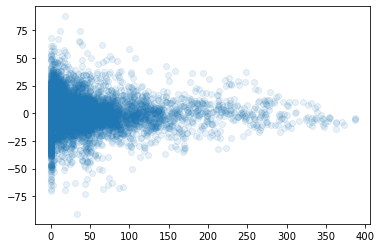

In [64]:
#plot a test scatter plot to make sure that everything seems to be working
plt.scatter('inf_change', 'nama_change', data = gov_covid, alpha = 0.1)

This plot seems to show a higher degree of variability and volatility in approval rating for states with smaller changes in cases. However, it is not really possible to tell just from this single plot, so I am going to take this dataset over to R, and see what additional information I can learn there.

In [65]:
#create csv files contianing data for every sen/gov since 1/21
gov_covid.to_csv('gov_covid.csv')
senate_covid.to_csv('sen_covid.csv')

In [66]:
#create csv files contianing data for every sen/gov since the otbreak began in their state
gov_outbreak_only = gov_covid[gov_covid['cases']!=0]
sen_outbreak_only = senate_covid[senate_covid['cases']!=0]

gov_outbreak_only.to_csv('gov_covid_outbreak.csv')
sen_outbreak_only.to_csv('sen_covid_outbreak.csv')